In [1]:
import numpy as np
import pandas as pd
import os
import csv
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import optuna
import random
import joblib

results_dir = '../results/syntheticdata/variables=[0,2]'
images_dir = '../images/syntheticdata/variables=[0,2]'
data_dir = '../data/syntheticdata/variables=[0,2]'

In [2]:
import torch
from torch import nn
from utils.train_pipeline import EarlyStopper, ModelTrainingPipeline, run_optuna_study

seed = 1729

torch.backends.cudnn.benchmark = False
torch.use_deterministic_algorithms(True)
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":16:8"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

early_stopper = EarlyStopper(patience=10, min_delta=1e-5, min_epochs=100)
pipeline = ModelTrainingPipeline(device=device, early_stopper=early_stopper)
pipeline.set_seed(seed)

x = torch.rand(5, 3)
print(x)

tensor([[0.3126, 0.3791, 0.3087],
        [0.0736, 0.4216, 0.0691],
        [0.2332, 0.4047, 0.2162],
        [0.9927, 0.4128, 0.5938],
        [0.6128, 0.1519, 0.0453]])


In [3]:
#load data 
n = 100000 #number of data points
k = 3 #number of variables
p = 5 # pattern length
variable_indexes = np.arange(k)
variables_pattern = [0,2]

dataset_path = os.path.join(data_dir, "scenario1_n={}_k={}_p={}_min_step={}_max_step={}_variables={}.csv".format(n, k, p, 5, 45, variables_pattern))
motif_indexes_path = os.path.join(data_dir, "motif_indexes_scenario1_n={}_k={}_p={}_min_step={}_max_step={}.csv".format(n, k, p, 5, 45))
data = np.genfromtxt(dataset_path, delimiter=",").astype(int).reshape((k, n))
motif_indexes = np.genfromtxt(motif_indexes_path, delimiter=",").astype(int)

print(motif_indexes)


[    0    10    22 ... 99922 99956 99992]


TRAIN: [    0     1     2 ... 15997 15998 15999] TEST: [16000 16001 16002 ... 19997 19998 19999]
TRAIN: [20000 20001 20002 ... 35997 35998 35999] TEST: [36000 36001 36002 ... 39997 39998 39999]
TRAIN: [40000 40001 40002 ... 55997 55998 55999] TEST: [56000 56001 56002 ... 59997 59998 59999]
TRAIN: [60000 60001 60002 ... 75997 75998 75999] TEST: [76000 76001 76002 ... 79997 79998 79999]
TRAIN: [80000 80001 80002 ... 95997 95998 95999] TEST: [96000 96001 96002 ... 99997 99998 99999]


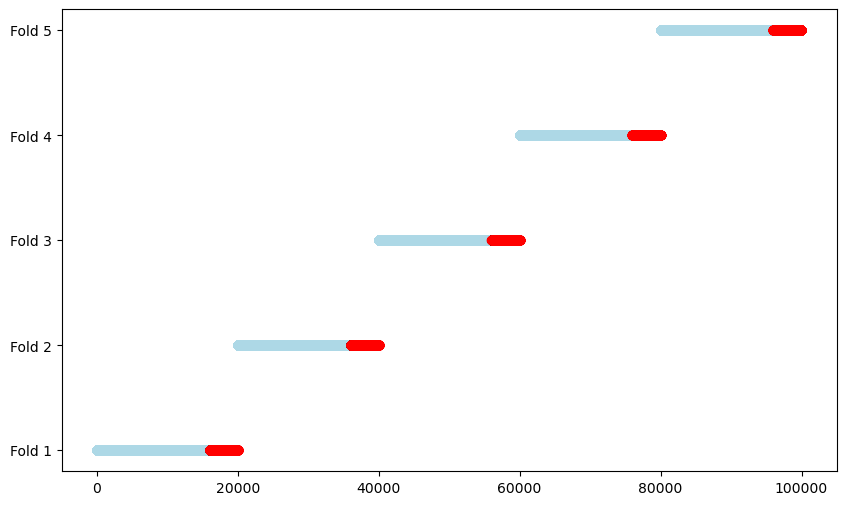

In [4]:
from utils.timeseries_split import BlockingTimeSeriesSplit

#create index  
indexes = np.arange(len(data[0]))

#split data
tscv = BlockingTimeSeriesSplit(n_splits=5)
# Create the figure
fig, ax = plt.subplots(figsize=(10, 6))
for i, (train_index, test_index) in enumerate(tscv.split(indexes)):
    # Plot train and test indices
    ax.plot(train_index, np.zeros_like(train_index) + i, 'o', color='lightblue')
    ax.plot(test_index, np.zeros_like(test_index) + i, 'o', color='red')
    print("TRAIN:", train_index, "TEST:", test_index)
    

ax.set_yticks(np.arange(5), ["Fold {}".format(i) for i in range(1, 6)])
plt.show()

In [5]:
from utils.utils import create_dataset

lookback_period = 100 #window size
step = 5 #step size for the sliding window
forecast_period = 50 #forward window size

#x1: past window, x2: indexes of the motif in the window,  y: next relative index of the motif
X1, X2, y = create_dataset(data, variable_indexes, lookback_period, step, forecast_period, motif_indexes)

# X1, X2, and y are now PyTorch tensors
print("X1 shape:", X1.shape)  # Expected shape: (num_samples, lookback_period, num_features)
print("X2 shape:", X2.shape)  # Expected shape: (num_samples, max_motif_length_in_window)
print("y shape:", y.shape)    # Expected shape: (num_samples, 1)


X1 shape: torch.Size([19979, 100, 3])
X2 shape: torch.Size([19979, 6, 1])
y shape: torch.Size([19979, 1])


[I 2024-12-13 16:40:22,075] A new study created in memory with name: no-name-e1ef96bf-b4c6-44f0-aaa2-f5e6336742fa


Training completed all epochs. Best epoch was 49
Training completed all epochs. Best epoch was 49
Training completed all epochs. Best epoch was 49
Training completed all epochs. Best epoch was 49


[I 2024-12-13 16:40:32,200] Trial 0 finished with value: 145.36965637207032 and parameters: {'learning_rate': 2.6565450821928437e-05, 'num_layers': 3, 'batch_size': 128, 'hidden_size_layer_0': 64, 'hidden_size_layer_1': 64, 'hidden_size_layer_2': 16}. Best is trial 0 with value: 145.36965637207032.


Training completed all epochs. Best epoch was 49
Best hyperparameters: {'learning_rate': 2.6565450821928437e-05, 'num_layers': 3, 'batch_size': 128, 'hidden_size_layer_0': 64, 'hidden_size_layer_1': 64, 'hidden_size_layer_2': 16}
Number of finished trials:  1
Best trial: 0
Best hyperparameters: {'learning_rate': 2.6565450821928437e-05, 'num_layers': 3, 'batch_size': 128, 'hidden_size_layer_0': 64, 'hidden_size_layer_1': 64, 'hidden_size_layer_2': 16}
Validation Losses: [140.15, 160.477, 140.279, 146.459, 139.484]
Mean validation loss: 145.37
Test Losses: [139.068, 162.169, 139.684, 142.691, 140.142]
Mean test loss: 144.751
Mean test MAE: 9.835 std: 0.054
Mean test RMSE: 12.026 std: 0.358


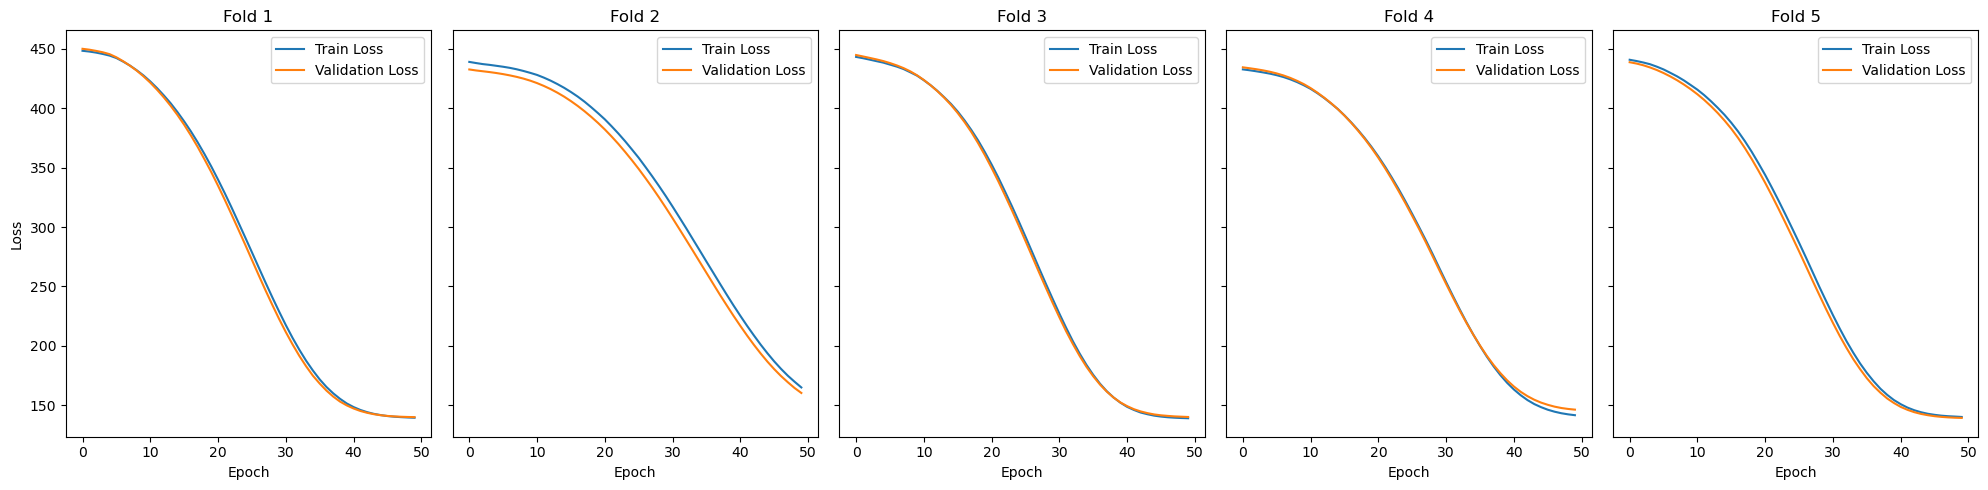

In [6]:
from models.ffnn_pytorch import FFNNX1
from utils.utils import print_study_results, plot_best_model_results

n_trials = 100
num_epochs = 500
model_type = "FFNN"
model_name = "FFNNX1"

suggestion_dict = {
    "learning_rate": {
        "type": "float",
        "args": [1e-5, 1e-3], 
        "kwargs": {"log": True} 
    },
    "num_layers": {
        "type": "categorical",
        "args": [[1, 2, 3, 4]] 
    },        
    "batch_size": {
        "type": "categorical",
        "args": [[16, 32, 64, 128]] 
    }
}

model_params_keys = ["hidden_sizes_list"]


result_dir = os.path.join(results_dir, f"{model_name}_{n_trials}_trials_{num_epochs}_epochs")
os.makedirs(result_dir, exist_ok=True)  

run_optuna_study(pipeline.run_cross_val, FFNNX1, model_type,suggestion_dict,  model_params_keys, seed, X1, None, y, result_dir, n_trials=n_trials, num_epochs=num_epochs)

study = joblib.load(os.path.join(result_dir, "study.pkl"))
print_study_results(study)
plot_best_model_results(study.trials_dataframe(), save_path=os.path.join(images_dir, f"{model_name}_{n_trials}_trials_{num_epochs}_epochs_losses.png"))

In [7]:
# # from utils.utils import plot_preds_vs_truevalues
# # from utils.train_pipeline import get_preds_best_config


# # epochs_train_losses, epochs_val_losses, all_predictions, all_true_values = get_preds_best_config(study, pipeline, FFNNX1, model_type, model_params_keys, num_epochs =num_epochs, seed=seed, X1=X1, X2=None, y=y)

# # # Plot the train and validation losses for each fold
# # fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(20, 5), sharey=True)
# # for i in range(5):
# #     axes[i].plot(epochs_train_losses[i], label="Train Loss")
# #     axes[i].plot(epochs_val_losses[i], label="Validation Loss")
# #     axes[i].set_title(f"Fold {i + 1}")
# #     axes[i].set_xlabel("Epoch")
# #     if i == 0:
# #         axes[i].set_ylabel("Loss")
# #     axes[i].legend()

# # plt.tight_layout()
# # plt.savefig(os.path.join(images_dir, f"{model_name}_{n_trials}_trials_{num_epochs}_epochs_losses.png"))
# # plt.show()

# # # Plot the predictions vs true values for each fold
# # for fold in range(5):
# #     plot_preds_vs_truevalues(np.ravel(all_true_values[fold]), np.ravel(all_predictions[fold]), fold, save_path=os.path.join(images_dir, f"{model_name}_{n_trials}_trials_{num_epochs}_epochs_fold_{fold}_predictions.png"))

#   for fold in range(5):
#     img = mpimg.imread(os.path.join(images_dir, f"{model_name}_{n_trials}_trials_{num_epochs}_epochs_fold_{fold}_predictions.png"))
#     plt.figure(figsize=(10, 10))
#     plt.imshow(img)
#     plt.axis('off')  # Hide axes for a cleaner display
#     plt.show()

[I 2024-12-13 16:40:32,705] A new study created in memory with name: no-name-f48df004-9e4f-4824-8c5a-d5b4f5c30b36


Training completed all epochs. Best epoch was 49
Training completed all epochs. Best epoch was 49
Training completed all epochs. Best epoch was 49
Training completed all epochs. Best epoch was 49


[I 2024-12-13 16:40:56,079] Trial 0 finished with value: 135.11253356933594 and parameters: {'learning_rate': 2.6565450821928437e-05, 'num_layers': 5, 'batch_size': 64, 'hidden_size_layer_0': 32, 'hidden_size_layer_1': 32, 'hidden_size_layer_2': 32, 'hidden_size_layer_3': 128, 'hidden_size_layer_4': 16}. Best is trial 0 with value: 135.11253356933594.


Training completed all epochs. Best epoch was 49
Best hyperparameters: {'learning_rate': 2.6565450821928437e-05, 'num_layers': 5, 'batch_size': 64, 'hidden_size_layer_0': 32, 'hidden_size_layer_1': 32, 'hidden_size_layer_2': 32, 'hidden_size_layer_3': 128, 'hidden_size_layer_4': 16}
Number of finished trials:  1
Best trial: 0
Best hyperparameters: {'learning_rate': 2.6565450821928437e-05, 'num_layers': 5, 'batch_size': 64, 'hidden_size_layer_0': 32, 'hidden_size_layer_1': 32, 'hidden_size_layer_2': 32, 'hidden_size_layer_3': 128, 'hidden_size_layer_4': 16}
Validation Losses: [133.276, 136.105, 135.895, 140.172, 130.115]
Mean validation loss: 135.113
Test Losses: [132.771, 135.033, 135.031, 136.633, 131.109]
Mean test loss: 134.115
Mean test MAE: 9.696 std: 0.054
Mean test RMSE: 11.581 std: 0.084


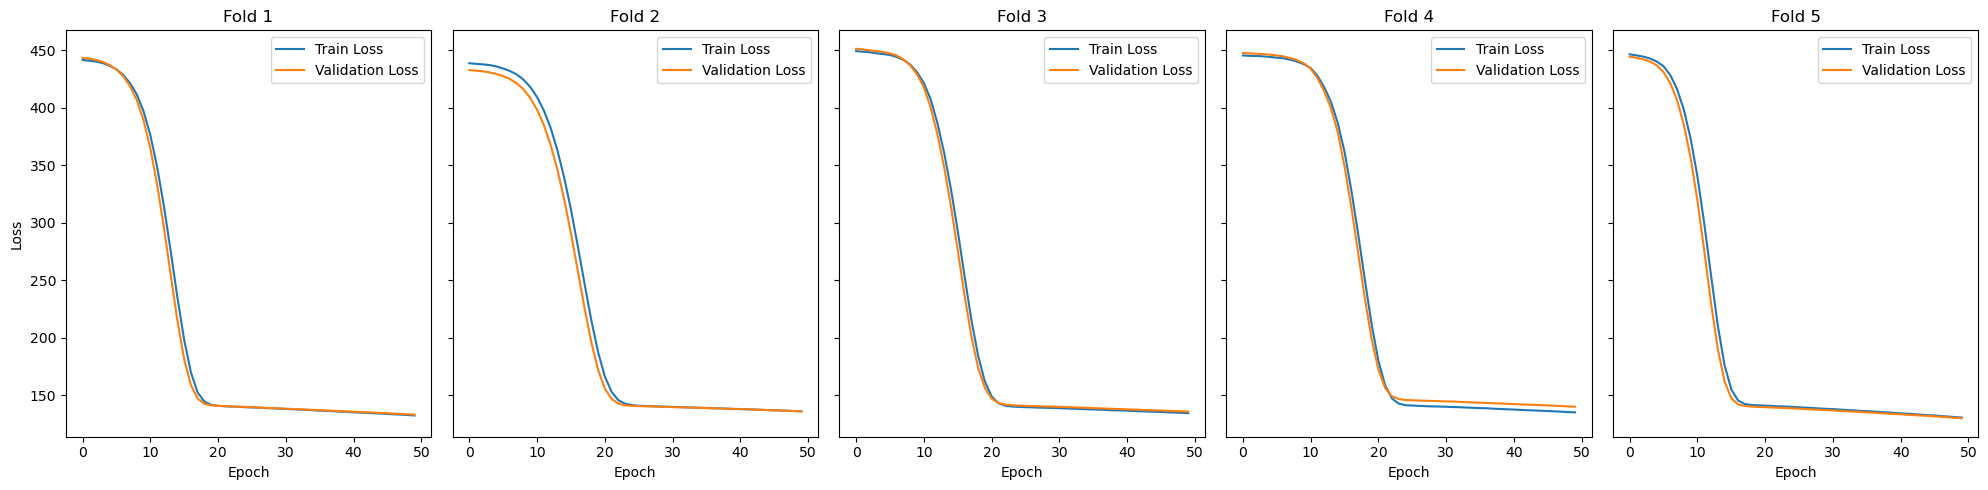

In [8]:
from models.ffnn_pytorch import FFNNX1Series_X2Masking
from utils.train_pipeline import EarlyStopper, ModelTrainingPipeline

n_trials = 100
num_epochs = 500
model_type = "FFNN"
model_name = "FFNNX1Series_X2Masking"

suggestion_dict = {
    "learning_rate": {
        "type": "float",
        "args": [1e-5, 1e-3], 
        "kwargs": {"log": True} 
    },
    "num_layers": {
        "type": "categorical",
        "args": [[1, 2, 3, 4, 5]] 
    },        
    "batch_size": {
        "type": "categorical",
        "args": [[16, 32, 64, 128]] 
    }
}

model_params_keys = ["hidden_sizes_list"]

#X1 shape is (num_samples, lookback_period, num_features)
masking_X1 = np.zeros((X1.shape[0], X1.shape[1])) 

for i, obs_motif_indexes in enumerate(X2):
    for j, idx in enumerate(obs_motif_indexes):
        masking_X1[i, idx.item():idx.item()+p] = 1

masking_X1 = torch.tensor(masking_X1, dtype=torch.float32)


result_dir = os.path.join(results_dir, f"{model_name}_{n_trials}_trials_{num_epochs}_epochs")
os.makedirs(result_dir, exist_ok=True)  

run_optuna_study(pipeline.run_cross_val, FFNNX1Series_X2Masking, model_type, suggestion_dict, model_params_keys, seed, X1, masking_X1, y, result_dir, n_trials=n_trials, num_epochs=num_epochs)

study = joblib.load(os.path.join(result_dir, "study.pkl"))
print_study_results(study)
plot_best_model_results(study.trials_dataframe(), save_path=os.path.join(images_dir, f"{model_name}_{n_trials}_trials_{num_epochs}_epochs_losses.png"))


In [9]:
# # from utils.utils import plot_preds_vs_truevalues
# # from utils.train_pipeline import get_preds_best_config


# # epochs_train_losses, epochs_val_losses, all_predictions, all_true_values = get_preds_best_config(study, pipeline, FFNNX1_X2Masking, model_type, model_params_keys, num_epochs =num_epochs, seed=seed, X1=X1, X2=masking_X1, y=y)

# # # Plot the train and validation losses for each fold
# # fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(20, 5), sharey=True)
# # for i in range(5):
# #     axes[i].plot(epochs_train_losses[i], label="Train Loss")
# #     axes[i].plot(epochs_val_losses[i], label="Validation Loss")
# #     axes[i].set_title(f"Fold {i + 1}")
# #     axes[i].set_xlabel("Epoch")
# #     if i == 0:
# #         axes[i].set_ylabel("Loss")
# #     axes[i].legend()

# # plt.tight_layout()
# # plt.savefig(os.path.join(images_dir, f"{model_name}_{n_trials}_trials_{num_epochs}_epochs_losses.png"))
# # plt.show()

# for fold in range(5):
#     img = mpimg.imread(os.path.join(images_dir, f"{model_name}_{n_trials}_trials_{num_epochs}_epochs_fold_{fold}_predictions.png"))
#     plt.figure(figsize=(10, 10))
#     plt.imshow(img)
#     plt.axis('off')  # Hide axes for a cleaner display
#     plt.show()


[I 2024-12-13 16:40:56,429] A new study created in memory with name: no-name-232977de-85d5-4f99-8bac-b660d0b1b730


Training completed all epochs. Best epoch was 49
Training completed all epochs. Best epoch was 49
Training completed all epochs. Best epoch was 49
Training completed all epochs. Best epoch was 49


[I 2024-12-13 16:41:03,240] Trial 0 finished with value: 406.80645141601565 and parameters: {'learning_rate': 2.6565450821928437e-05, 'num_layers': 3, 'batch_size': 128, 'hidden_size_layer_0': 64, 'hidden_size_layer_1': 64, 'hidden_size_layer_2': 16}. Best is trial 0 with value: 406.80645141601565.


Training completed all epochs. Best epoch was 49
Best hyperparameters: {'learning_rate': 2.6565450821928437e-05, 'num_layers': 3, 'batch_size': 128, 'hidden_size_layer_0': 64, 'hidden_size_layer_1': 64, 'hidden_size_layer_2': 16}
Number of finished trials:  1
Best trial: 0
Best hyperparameters: {'learning_rate': 2.6565450821928437e-05, 'num_layers': 3, 'batch_size': 128, 'hidden_size_layer_0': 64, 'hidden_size_layer_1': 64, 'hidden_size_layer_2': 16}
Validation Losses: [422.868, 398.294, 396.334, 403.647, 412.889]
Mean validation loss: 406.806
Test Losses: [419.442, 406.158, 394.337, 405.309, 412.424]
Mean test loss: 407.534
Mean test MAE: 16.343 std: 0.237
Mean test RMSE: 20.186 std: 0.206


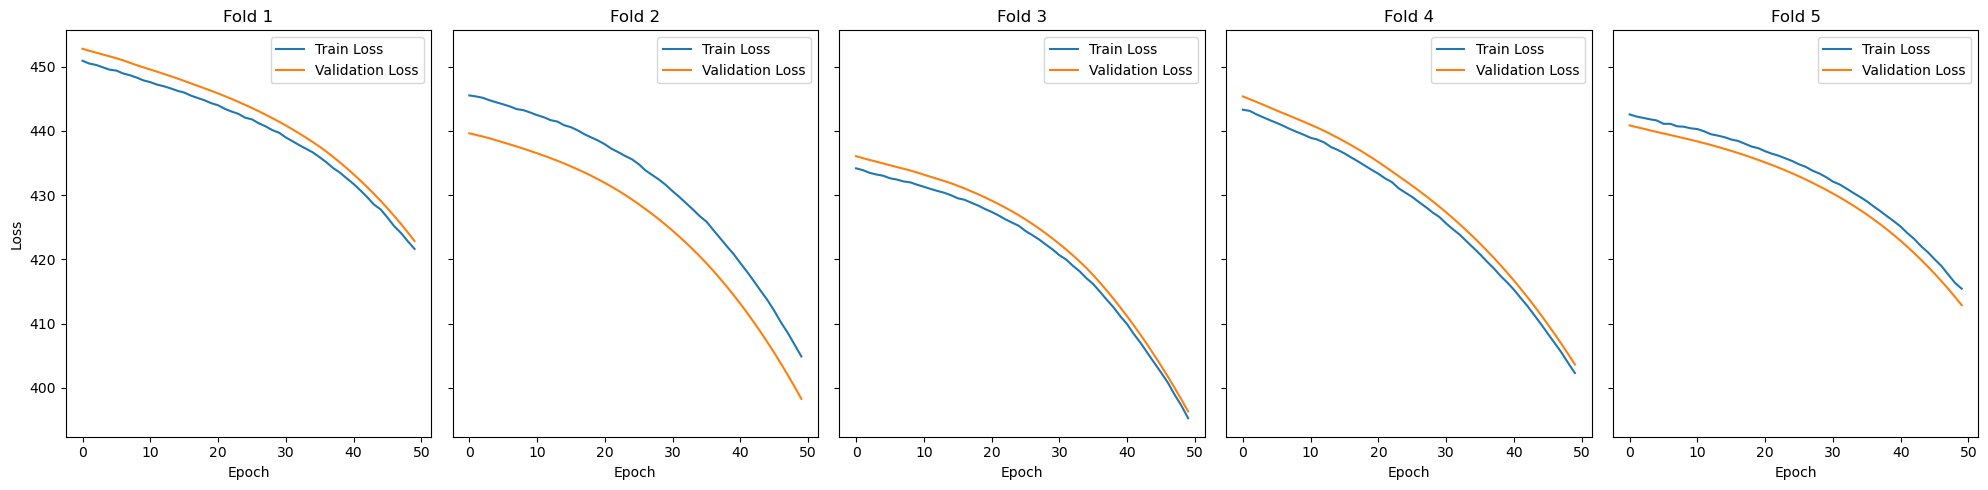

In [ ]:
from models.ffnn_pytorch import FFNNX1
from utils.utils import print_study_results, plot_best_model_results

n_trials = 100
num_epochs = 500
model_type = "FFNN"
model_name = "FFNNX1_Indexes"

suggestion_dict = {
    "learning_rate": {
        "type": "float",
        "args": [1e-5, 1e-3], 
        "kwargs": {"log": True} 
    },
    "num_layers": {
        "type": "categorical",
        "args": [[1, 2, 3, 4]] 
    },        
    "batch_size": {
        "type": "categorical",
        "args": [[16, 32, 64, 128]] 
    }
}

model_params_keys = ["hidden_sizes_list"]


result_dir = os.path.join(results_dir, f"{model_name}_{n_trials}_trials_{num_epochs}_epochs")
os.makedirs(result_dir, exist_ok=True)  

run_optuna_study(pipeline.run_cross_val, FFNNX1, model_type,suggestion_dict,  model_params_keys, seed, X2, None, y, result_dir, n_trials=n_trials, num_epochs=num_epochs)

study = joblib.load(os.path.join(result_dir, "study.pkl"))
print_study_results(study)
plot_best_model_results(study.trials_dataframe(), save_path=os.path.join(images_dir, f"{model_name}_{n_trials}_trials_{num_epochs}_epochs_losses.png"))